## 프로그램 실행 준비 단계입니다
- 라이브러리 불러오기, 변수 및 함수 선언으로 구성돼 있습니다
- 한번 실행하면 노트북이 켜져 있는 한 이 부분은 반복해서 실행할 필요가 없습니다
- 사진은 이 노트북 파일이 존재하는 경로 아래 raw/ 폴더에 종류별로 넣어주세요.

In [ ]:
# drive.mount('/content/drive/', force_remount=True)

In [ ]:
#tensorflow cpu 버전 업그레이드 필요시만 사용하세요.
# %pip install --upgrade tensorflow-cpu
# %pip install --upgrade tensorflow-gpu
# %pip install --upgrade tensorflow
# %pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [2]:
# 아래 두 모듈은 로컬에서는 필요 없음
# from google.colab import drive  # access files in the gdrive
# from google.colab.patches import cv2_imshow

import os  # for treating files
import re  # for natural sort and test image moving
import shutil # recursively remove directories
import time # measure deep-learning time
import pathlib
import numpy as np

# CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend

# img preprocess
import cv2

# augmentation of the raw train sets - not used any more
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
# from keras.preprocessing.image import load_img

# InceptionV3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3


# InceptionResNetV2 model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Matplotlib
import matplotlib.pyplot as plt

In [ ]:
# CNN 모델 학습 부분이 실패할 경우 오류를 보고 이 셀을 실행할지 결정(Colab 상에서 실행할 경우 필요 없습니다)
import sys
from PIL import Image

In [ ]:
word = {'' : 0, 'da' : 1, 'sa' : 2, 'aa' : 3, 'ka' : 4}

In [3]:
# Databox: 프로그램 내에서 쓰일 변수 모음입니다. 
dir_raw      = pathlib.Path("./raw")   # 원본 이미지 경로
dir_backup   = pathlib.Path("./backup") # 백업 이미지 경로
dir_datasets = pathlib.Path("./train")  # 모델 학습 기초가 될 경로
dir_test     = pathlib.Path("./test")

class_list = os.listdir(dir_raw) # ['apple', 'orange', ...]


# 아래 변수들은 실제 쓰이는 셀에서 사용자의 입력을 받도록 옮겼습니다. 
# split_percent  # 만약 값이 0.3이면 testset의 비율을 3할로 조정합니다
# size_raw  # datasets/raw  내 각 항목의 이미지 개수
# size_test # datasets/test 내 각 과일의 이미지 개수(나중에 너무 크면 조정을 위해 남김)
# num_aug_per_img  # 한 이미지당 증폭 이미지가 몇 개 나오는지 설정

FileNotFoundError: ignored

In [ ]:
# Toolbox: 프로그램 내 함수 모음
def sort_nicely(l):
  """ 요소이름을 오름차순 정렬한다. 왜 쓰는지는 아래 이유가 있다: 
      expected: l1, l2, l3, ...
      result of sorted(l): l1, l10, l11, ..., l2, l20, ... """
  convert = lambda text: int(text) if text.isdigit() else text
  alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
  
  l.sort( key=alphanum_key )


def count_fruit_images(fruit_path):
  """ 과일 폴더들이 들어있는 경로(dir_raw)를 넣으면 
      각 폴더에 몇장의 이미지가 있는지 알려준다 """
  fruit_list = os.listdir(fruit_path)
  paths_fruit = [os.path.join(fruit_path, fruit) for fruit in fruit_list]

  num_each_fruit = zip(fruit_list, [len(os.listdir(path)) for path in paths_fruit])
  for f, n in num_each_fruit:
    print('{1} images in {0}'.format(f, n))
  
  return [len(os.listdir(path)) for path in paths_fruit]


def cut_images_bysize(size, dir):
  """ 인자로 주어진 폴더 내 파일들을 정해진 개수만 남기고 제거
      남기는 기준은 오름차순으로 첫번째부터 size번째 파일까지 """
  filelist = os.listdir(dir)
  sort_nicely(filelist)
  for img in filelist[size:len(filelist)]:
    img_remove = os.path.join(dir, img)
    os.remove(img_remove)
    
  print("images in {0} removed".format(dir))


def extract_fruit_name(path):
  """ 파일의 완전한 경로든, 파일명만 있든 인자에서 과일명을 찾아낸다 """
  filename = os.path.basename(path)
  sep_bar = filename.rfind("-")
  return filename[0: sep_bar]


def move_images(ratio, src, dest):
  """ src 내에서 ratio만큼의 이미지들을 한번에 dest로 옮긴다
      updated: move images even if the 'dest' does not exist.
      if ratio >= 1, interpret 'ratio' as number of images """
  list_img = os.listdir(src)
  sort_nicely(list_img)

  if ratio <= 1:
    split_index = int((1 - ratio) * len(list_img))
  else:
    split_index = len(list_img) - ratio
  split_index = int(split_index)

  if not os.path.isdir(dest):
    print("Path {0} created".format(dest))
    os.makedirs(dest)
  for img in list_img[split_index:len(list_img)]:
      os.rename(os.path.join(src, img), os.path.join(dest, img))


def change_image_name(aftername, filepath):
  """ <filepath>안에 들어있는 파일들의 이름을 <aftername>-<number>형식으로 바꾼다.
      원래 확장자는 유지되며, 번호는 임의대로 매겨진다. 
      배경 있는 이미지를 test로 넣고 학습하는 데 쓰였다 """
  
  file_list = os.listdir(filepath)

  for i, f in enumerate(file_list):
    beforename, ext = os.path.splitext(f)
    src =  os.path.join(filepath, "{0}{1}".format(beforename, ext))
    dest = os.path.join(filepath, "{0}-{1}{2}".format(aftername, i, ext))

    os.rename(src, dest)
  print("names of image in dir {0} has all changed.".format(aftername))


def plt_show_loss(history):
  """ 모델의 훈련, 검증 결과의 loss를 보여준다 """

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model_Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','Test'], loc=0)


def plt_show_acc(history):
  """ 모델의 훈련, 검증 결과의 accuracy를 보여준다 """
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model_accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Test'], loc=0)


def input_with_default(default_val, prompt_msg):
  """ get integer input from user, but return default value 
      if fail to get any value """

  val = input(prompt_msg)
  if len(val) == 0:
    val = default_val
  else:
    val = float(val)
  
  return val

In [ ]:
import os
import cv2
import pathlib

In [ ]:
# # Make broken images compatible

# # 돌아댕기면서 cv2.imread(img_path) -> cv2.imwrite(filename, image)
# for category in os.listdir(pathlib.Path(dir_raw)):
#     for idx, img in enumerate(os.listdir(os.path.join(dir_raw, category))):
#         img_path = os.path.join(dir_raw, category, img)

#         # _, ext = os.path.splitext(img_path)      
#         # os.rename(img_path, os.path.join(dir_raw, category, "{}-{}{}".format(category, idx+10000, ext)))
        
#         img_obj = cv2.imread(img_path)
#         try:
#             cv2.imwrite(os.path.join(dir_raw, category, img), img_obj)
#         except Exception:
#             print(img_path)
#         finally:
#             continue

## 본격적인 실험 시작 부분입니다

In [ ]:
# 현재 원본 이미지가 몇 장인지 확인하세요
count_fruit_images(dir_raw)

256 images in almond
200 images in apple
200 images in broccoli
200 images in carrot
200 images in grape
226 images in mandarin
200 images in melon
200 images in onion
200 images in welshOnion


[256, 200, 200, 200, 200, 226, 200, 200, 200]

In [ ]:
# 실험 속도를 위해 정해진 개수(size_raw)만 남기고 클래스별 raw 데이터를 backup 폴더로 치워버립니다
# 남기는 이미지들은 파일명 오름차순으로 1~size_raw입니다.

default_size = 20  # 초기값입니다. 입력 시 엔터만 누르면 이 값이 들어값니다. 원하시면 조정하세요  # 200입력
size_moved = input_with_default(default_size, 
  "raw 폴더에 클래스별 남길 이미지의 장 수를 입력하세요(디폴트: {0}): ".format(default_size))

for c in os.listdir(dir_raw):
  src_path  = os.path.join(dir_raw, c)
  dest_path = os.path.join(dir_backup, c)

  size_raw = len(os.listdir(src_path)) - size_moved
  move_images(size_raw, src_path, dest_path)

print('\nAll images has moved to backup folder.')

raw 폴더에 클래스별 남길 이미지의 장 수를 입력하세요(디폴트: 20): 200
Path backup\almond created
Path backup\apple created
Path backup\broccoli created
Path backup\carrot created
Path backup\grape created
Path backup\mandarin created
Path backup\melon created
Path backup\onion created
Path backup\welshOnion created

All images has moved to backup folder.


In [ ]:
# raw 폴더 내 이미지들이 제대로 백업됐는지 확인해 보세요
count_fruit_images(dir_backup)

56 images in almond
0 images in apple
0 images in broccoli
0 images in carrot
0 images in grape
26 images in mandarin
0 images in melon
0 images in onion
0 images in welshOnion


[56, 0, 0, 0, 0, 26, 0, 0, 0]

In [ ]:
# 훈련 및 검증을 위한 class 별 폴더들을 생성합니다(이미 생성돼 있다면 무시해도 좋습니다)
for c in class_list:
  target = os.path.join(dir_datasets, "class_" + c)
  # 접두사를 붙이는 이유는 tf.keras.preprocessing.image_dataset_from_directory가
  # 자동으로 클래스를 인식하기 때문입니다
  os.makedirs(target, exist_ok=True)
print("Directory for datasets has been made.")

# 테스트용 class별 폴더를 생성합니다
for c in class_list:
  target = os.path.join(dir_test, "class_" + c)
  # 접두사를 붙이는 이유는 tf.keras.preprocessing.image_dataset_from_directory가
  # 자동으로 클래스를 인식하기 때문입니다
  os.makedirs(target, exist_ok=True)
print("Directory for test has been made.")

Directory for datasets has been made.
Directory for test has been made.


In [ ]:
# 테스트로 잡은 이미지들을 test 폴더로 옮깁니다
split_percent = input_with_default(.3, "테스트 이미지 개수나, raw에 대한 비율을 입력하세요(기본값: 0.3)): ")

for c in class_list:
  image_list = os.path.join(dir_raw, c)
  sort_nicely(os.listdir(image_list))

  src  = os.path.join(dir_raw,  c)
  dest = os.path.join(dir_test, "class_" + c)

  # 테스트 내 과일별로 빈 폴더만 채우도록 했습니다.
  if os.path.isdir(dest) and len(os.listdir(dest)) == 0:
    move_images(split_percent, src, dest)
    print("{0} images for test has moved.".format(c))
  else:
    print("Moving {0} images for test has canceled because it's not empty.".format(c))

테스트 이미지 개수나, raw에 대한 비율을 입력하세요(기본값: 0.3)): 0.3
almond images for test has moved.
apple images for test has moved.
broccoli images for test has moved.
carrot images for test has moved.
grape images for test has moved.
mandarin images for test has moved.
melon images for test has moved.
onion images for test has moved.
welshOnion images for test has moved.


In [6]:
# datasets로 잡은 이미지들을 datasets 폴더로 옮깁니다
for c in class_list:
  image_list = os.path.join(dir_raw, c)
  sort_nicely(os.listdir(image_list))

  src  = os.path.join(dir_raw,  c)
  dest = os.path.join(dir_datasets, "class_" + c)

  # 테스트 내 과일별로 빈 폴더만 채우도록 했습니다.
  if os.path.isdir(dest) and len(os.listdir(dest)) == 0:
    move_images(1, src, dest)
    print("{0} images for datasets has moved.".format(c))
  else:
    print("Moving {0} images for datasets has canceled because it's not empty.".format(c))


almond images for datasets has moved.
apple images for datasets has moved.
broccoli images for datasets has moved.
carrot images for datasets has moved.
grape images for datasets has moved.
mandarin images for datasets has moved.
melon images for datasets has moved.
onion images for datasets has moved.
welshOnion images for datasets has moved.


In [ ]:
# 이미지가 test와 datasets로 제대로 옮겨졌는지 확인해 봅시다
print('num of images in test directories: ')
count_fruit_images(dir_test)

print('\nnum of images in datasets directories: ')
count_fruit_images(dir_datasets)

num of images in test directories: 
60 images in class_almond
60 images in class_apple
60 images in class_broccoli
60 images in class_carrot
60 images in class_grape
60 images in class_mandarin
60 images in class_melon
60 images in class_onion
60 images in class_welshOnion

num of images in datasets directories: 
140 images in class_almond
140 images in class_apple
140 images in class_broccoli
140 images in class_carrot
140 images in class_grape
140 images in class_mandarin
140 images in class_melon
140 images in class_onion
140 images in class_welshOnion


[140, 140, 140, 140, 140, 140, 140, 140, 140]

## 이미지 분류기의 학습 단계

In [ ]:
image_size = int(input_with_default(100, "모델이 이미지를 받아들일 크기(가로==세로)를 입력하세요(기본값은 100): "))
batch_size = int(input_with_default(10, "배치 사이즈(기본값은 10): "))  # 임시로 정했습니다

모델이 이미지를 받아들일 크기(가로==세로)를 입력하세요(기본값은 100): 100
배치 사이즈(기본값은 10): 10


In [ ]:
# 이젠 train에서 훈련하고, val으로 검증합니다. 이 둘은 datasets로 통합됐습니다.
# test 폴더는 서비스 런칭하면 사용자가 찍어 업로드하는 사진이 됩니다
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_datasets,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode='rgb',
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 1260 files belonging to 9 classes.
Using 1008 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_datasets,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode='rgb',
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 1260 files belonging to 9 classes.
Using 252 files for validation.


In [ ]:
# 이 부분은 마지막 test에서 판별한 이미지의 labeling에 쓰입니다
# 처음 선언하는 class_list는 파일 제어에 쓰입니다. 둘이 분리된 이유는 legacy 이유로 그렇습니다.
class_names = train_ds.class_names

In [ ]:
# Make broken images compatible

# 돌아댕기면서 cv2.imread(img_path) -> cv2.imwrite(filename, image)
# for category in os.listdir(pathlib.Path(dir_datasets)):
#     for img in os.listdir(os.path.join(dir_datasets, category)):
#         img_path = os.path.join(dir_datasets, category, img)
#
#         img_obj = cv2.imread(img_path)
#         try:
#             cv2.imwrite(os.path.join(dir_datasets, category[6:], img), img_obj)
#         except Exception:
#             print(img_path)
#         finally:
#             continue

In [ ]:
# 개수 비교
# for category in os.listdir(pathlib.Path(dir_datasets)):
#     print(category, end=": ")
#     print(len(os.listdir(os.path.join(pathlib.Path(dir_datasets), category))))

In [ ]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break
# The image_batch is a tensor of the shape (10, 100, 100, 3).
# This is a batch of 10 images of shape 100 * 100 * 3
# (the last dimension refers to color channels RGB).
# The label_batch is a tensor of the shape (10,),
# these are corresponding labels to the 10 images.

In [ ]:
# 색상값은 [0, 255] 범위입니다. 이를 레이어에 맞게 [0, 1] 범위로 정규화 시킬 필요가 있습니다.
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# 픽셀값이 [0, 255]에서 [0, 1]로 정규화 된 것이 보이시죠? 당 셀은 이를 보여주기 위함이고, 학습에서 정규화는 시퀄셜 레이어 안에 있습니다.
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 이제 이미지 증폭도 레이어를 쌓아 실현할 수 있습니다!
data_augmentation = keras.Sequential(
  [
      layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(image_size,
                                                              image_size,
                                                              3)),
      layers.experimental.preprocessing.RandomRotation(0.2),
      layers.experimental.preprocessing.RandomZoom(0.2),
      layers.experimental.preprocessing.RandomContrast(0.2),
      layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.2),
                                                          width_factor=(-0.2, 0.2),
                                                          fill_mode="constant",
                                                          interpolation="nearest"),

  ]
)

In [ ]:
num_classes = len(class_list)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  # Feature extract
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Classifier
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)       

In [ ]:
epochs = int(input_with_default(30, "에폭 크기를 결정하세요(기본값: 10): "))   # 에폭은 25이상으로 올려야 합니다.

start = time.time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
time_elapsed_learning = time.time() - start
print("학습에 걸린 시간(단위는 초) :", time_elapsed_learning)

에폭 크기를 결정하세요(기본값: 10): 55
Epoch 1/55
101/101 [==============================] - 8s 79ms/step - loss: 1.9866 - accuracy: 0.2054 - val_loss: 1.7326 - val_accuracy: 0.2421
Epoch 2/55
101/101 [==============================] - 7s 69ms/step - loss: 1.5232 - accuracy: 0.3790 - val_loss: 1.0801 - val_accuracy: 0.6230
Epoch 3/55
101/101 [==============================] - 7s 68ms/step - loss: 1.1632 - accuracy: 0.5714 - val_loss: 0.8855 - val_accuracy: 0.6349
Epoch 4/55
101/101 [==============================] - 7s 68ms/step - loss: 0.9970 - accuracy: 0.6349 - val_loss: 0.8085 - val_accuracy: 0.7063
Epoch 5/55
101/101 [==============================] - 7s 67ms/step - loss: 0.9593 - accuracy: 0.6409 - val_loss: 0.7896 - val_accuracy: 0.7024
Epoch 6/55
101/101 [==============================] - 7s 67ms/step - loss: 0.9136 - accuracy: 0.6657 - val_loss: 0.7356 - val_accuracy: 0.7381
Epoch 7/55
101/101 [==============================] - 7s 68ms/step - loss: 0.8669 - accuracy: 0.6915 - val_loss: 0.7

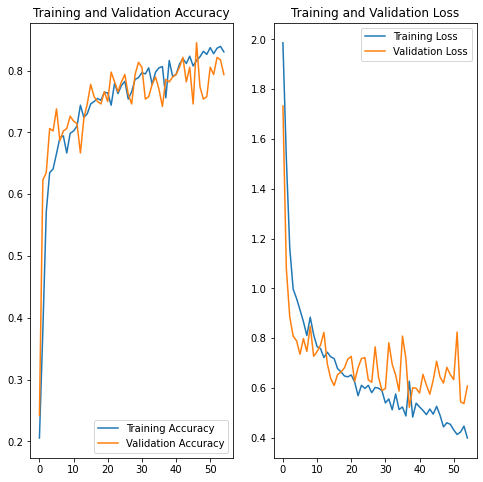

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 학습을 했으니, 새로운 데이터(test)로 시험(prediction or test)을 칩니다

In [ ]:
# 테스트 합니다. 바로 아래 줄의 과일 이름을 바꾸면 다른 카테고리 테스트 가능합니다
for cat in class_names:
    num_total = len(os.listdir(os.path.join(dir_test, cat)))
    num_correct = 0

    for img in os.listdir(os.path.join(dir_test, cat)):
        img_path = os.path.join(dir_test, cat, img)
        img = Image.open(img_path)
        img = img.resize((image_size, image_size))
        img = keras.preprocessing.image.img_to_array(img)
        img = tf.expand_dims(img, 0)

        predictions = model.predict(img)
        score = tf.nn.softmax(predictions[0])
        if cat == class_names[np.argmax(score)]:
            num_correct = num_correct + 1
    print("correct:{} of total {}, ratio: {:.2f} in category {}".format(num_correct, num_total, num_correct/num_total, cat))

correct:58 of total 60, ratio: 0.97 in category class_almond
correct:46 of total 60, ratio: 0.77 in category class_apple
correct:37 of total 60, ratio: 0.62 in category class_broccoli
correct:48 of total 60, ratio: 0.80 in category class_carrot
correct:60 of total 60, ratio: 1.00 in category class_grape
correct:46 of total 60, ratio: 0.77 in category class_mandarin
correct:47 of total 60, ratio: 0.78 in category class_melon
correct:37 of total 60, ratio: 0.62 in category class_onion
correct:50 of total 60, ratio: 0.83 in category class_welshOnion


In [ ]:
# 전체 test 이미지에 대한 추론 결과

for c in class_list:
    img_in_class = pathlib.Path(os.path.join(dir_test, c))
    img_list = [Image.open(img) for img in list(img_in_class.glob("./*"))]
    # img_list = [img.resize((image_size, image_size)) for img in img_list]
    img_array = [keras.preprocessing.image.img_to_array(img) for img in img_list]
    img_array = [tf.expand_dims(img, 0) for img in img_array] # Create a batch

    predictions = [model.predict(img) for img in img_array]
    scores = [tf.nn.softmax(pred[0]) for pred in predictions]

    for img, score in zip(list(img_in_class.glob("./*")), scores):
        with open('test_result', 'a+') as f:
            print("{} most likely belongs to {} with a {:.2f} percent confidence.".format(img.name, class_names[np.argmax(score)], 100 * np.max(score))
                  , file=f)


In [ ]:
# testset에 대해 (맞춘 이미지 수)/(testset 전체 이미지 수) 를 구해 보여줄 것
category_right = {
    'almond': 0, 'apple': 0, 'broccoli': 0, 'carrot': 0, 'grape': 0,
    'mandarin': 0, 'melon': 0, 'onion': 0, 'welshOnion': 0
}
num_problem = 0

for c in class_list:
    img_in_class = pathlib.Path(os.path.join(dir_test, "class_" + c))

    img_list = [Image.open(img) for img in list(img_in_class.glob("./*"))]
    img_list = [img.resize((image_size, image_size)) for img in img_list]
    img_array = [keras.preprocessing.image.img_to_array(img) for img in img_list]
    img_array = [tf.expand_dims(img, 0) for img in img_array] # Create a batch

    predictions = [model.predict(img) for img in img_array]
    scores = [tf.nn.softmax(pred[0]) for pred in predictions]

    for img, score in zip(list(img_in_class.glob("./*")), scores):
        num_problem = num_problem + 1

        correct = img.name
        print(img.name)
        answer  = class_names[np.argmax(score)]
        if correct == answer:
            category_right[correct] = category_right[correct] + 1

almond-10140.jpg
almond-10141.jpg
almond-10142.jpg
almond-10143.jpg
almond-10144.jpg
almond-10145.jpg
almond-10146.jpg
almond-10147.jpg
almond-10148.jpg
almond-10149.jpg
almond-10150.jpg
almond-10151.jpg
almond-10152.jpg
almond-10153.jpg
almond-10154.jpg
almond-10155.jpg
almond-10156.jpg
almond-10157.jpg
almond-10158.jpg
almond-10159.jpg
almond-10160.jpg
almond-10161.jpg
almond-10162.jpg
almond-10163.jpg
almond-10164.jpg
almond-10165.jpg
almond-10166.jpg
almond-10167.jpg
almond-10168.jpg
almond-10169.jpg
almond-10170.jpg
almond-10171.jpg
almond-10172.jpg
almond-10173.jpg
almond-10174.jpg
almond-10175.jpg
almond-10176.jpg
almond-10177.jpg
almond-10178.jpg
almond-10179.jpg
almond-10180.jpg
almond-10181.jpg
almond-10182.jpg
almond-10183.jpg
almond-10184.jpg
almond-10185.jpg
almond-10186.jpg
almond-10187.jpg
almond-10188.jpg
almond-10189.jpg
almond-10190.jpg
almond-10191.jpg
almond-10192.jpg
almond-10193.jpg
almond-10194.jpg
almond-10195.jpg
almond-10196.jpg
almond-10197.jpg
almond-10198.j

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/cnn_epoch46_batch_32')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/cnn_epoch46_batch_32\assets


In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

OSError: SavedModel file does not exist at: saved_model/my_model/{saved_model.pbtxt|saved_model.pb}

### 새로 실험을 시작하려면 아래 두 셀을 실행하시면 됩니다


In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

print(new_model.predict(test_images).shape)


NameError: name 'new_model' is not defined

In [ ]:
# 이동시켰던 test용 이미지들을 다시 원래 raw/ 아래 과일별 폴더로 옮깁니다
for c in class_list:
  src =  os.path.join(dir_test, "class_" + c)
  dest = os.path.join(dir_raw, c)
  move_images(1, src, dest)
  print("{0} images for test has moved back " \
        "to original raw directory.".format(c))

print('\ntest directory:')
count_fruit_images(dir_test)
print("")

# dataset
for c in class_list:
  src =  os.path.join(dir_datasets, "class_" + c)
  dest = os.path.join(dir_raw, c)
  move_images(1, src, dest)
  print("{0} images for datasets has moved back " \
        "to original raw directory.".format(c))

print('\ntest directory:')
count_fruit_images(dir_datasets)
print("")

# 백업용 폴더로 옮겼던 이미지들도 다시 raw로 옮깁니다
for c in class_list:
  src =  os.path.join(dir_backup, c)
  dest = os.path.join(dir_raw, c)
  move_images(1, src, dest)
  print("{0} images for backup has moved back " \
        "to original raw directory.".format(c))
  
print('\nbackup directory:')
count_fruit_images(dir_backup)


almond images for test has moved back to original raw directory.
apple images for test has moved back to original raw directory.
broccoli images for test has moved back to original raw directory.
carrot images for test has moved back to original raw directory.
grape images for test has moved back to original raw directory.
mandarin images for test has moved back to original raw directory.
melon images for test has moved back to original raw directory.
onion images for test has moved back to original raw directory.
welshOnion images for test has moved back to original raw directory.

test directory:
0 images in class_almond
0 images in class_apple
0 images in class_broccoli
0 images in class_carrot
0 images in class_grape
0 images in class_mandarin
0 images in class_melon
0 images in class_onion
0 images in class_welshOnion

almond images for datasets has moved back to original raw directory.
apple images for datasets has moved back to original raw directory.
broccoli images for dataset

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# raw 폴더 안을 확인해서 이미지들이 제대로 돌아왔나 봅시다
print('images in backup: ')
count_fruit_images(dir_backup)

print('\nimages in test: ')
count_fruit_images(dir_test)

print('\nimages in raw: ')
count_fruit_images(dir_raw)

images in backup: 
0 images in almond
0 images in apple
0 images in broccoli
0 images in carrot
0 images in grape
0 images in mandarin
0 images in melon
0 images in onion
0 images in welshOnion

images in test: 
0 images in class_almond
0 images in class_apple
0 images in class_broccoli
0 images in class_carrot
0 images in class_grape
0 images in class_mandarin
0 images in class_melon
0 images in class_onion
0 images in class_welshOnion

images in raw: 
256 images in almond
200 images in apple
200 images in broccoli
200 images in carrot
200 images in grape
226 images in mandarin
200 images in melon
200 images in onion
200 images in welshOnion


[256, 200, 200, 200, 200, 226, 200, 200, 200]

In [ ]:
# train과 test, 그리고 backup 폴더를 지웁니다
shutil.rmtree(dir_test)
shutil.rmtree(dir_datasets)
shutil.rmtree(dir_backup)